In [2]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
import sys
from torch.utils.data import Dataset, DataLoader
import torchvision
from spconv.pytorch import SparseConvTensor, SubMConv3d, SparseConv3d, SparseInverseConv3d
import argparse
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from datasets.kradar_detection_v2_0 import KRadarDetection_v2_0
from dataset_utils.KDataset import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [89]:
d = 'cuda' if torch.cuda.is_available() else 'cpu'
# cfg_path = './configs/cfg_rdr_ldr.yml'
cfg_path = './configs/cfg_rdr_ldr.yml'
cfg = cfg_from_yaml_file(cfg_path, cfg)

x_min, y_min, z_min, x_max, y_max, z_max = cfg.DATASET.roi.xyz
vsize_xyz = cfg.DATASET.roi.voxel_size
x_size = int(np.floor((x_max-x_min)/vsize_xyz[0]))
y_size = int(np.floor((y_max-y_min)/vsize_xyz[1]))
z_size = int(np.floor((z_max-z_min)/vsize_xyz[2]))
print(f'zyx-size: {z_size}, {y_size}, {x_size}')
# origin = torch.tensor([x_min, y_min, z_min]).to(d)
# vsize_xyz = torch.tensor(vsize_xyz).to(d)

bs=1
train_kdataset = KRadarDetection_v2_0(cfg=cfg, split='train')
train_dataloader = DataLoader(train_kdataset, batch_size=bs, 
                                collate_fn=train_kdataset.collate_fn, num_workers=0, shuffle=False)

test_kdataset = KRadarDetection_v2_0(cfg=cfg, split='test')
test_dataloader = DataLoader(test_kdataset, batch_size=bs, 
                        collate_fn=test_kdataset.collate_fn, num_workers=0, shuffle=False)

rdr_processor = RadarSparseProcessor(cfg)
ldr_processor = LdrPreprocessor(cfg)
simplified_pointnet = nn.Linear(4, 32, bias=False).to(d)

zyx-size: 95, 640, 1440


In [4]:
batchdata = next(iter(train_dataloader))
print(batchdata.keys())

dict_keys(['meta', 'ldr64', 'rdr_sparse', 'label', 'num_objs', 'gt_boxes', 'batch_size', 'batch_indices_ldr64', 'batch_indices_rdr_sparse'])


In [5]:
print(batchdata['meta'])

[{'header': '/home/juntingd/research/3DImage/lidar/K-radar/data/sequences', 'seq': '1', 'label_v1_0': '/home/juntingd/research/3DImage/lidar/K-radar/data/sequences/1/info_label/00033_00001.txt', 'label_v1_1': '/home/juntingd/research/3DImage/lidar/K-radar/K-Radar/tools/revise_label/kradar_revised_label_v1_1/1_info_label_revised/00033_00001.txt', 'label_v2_0': '/home/juntingd/research/3DImage/lidar/K-radar/K-Radar/tools/revise_label/kradar_revised_label_v2_0/KRadar_refined_label_by_UWIPL/1/00033_00001.txt', 'label_v2_1': '/home/juntingd/research/3DImage/lidar/K-radar/K-Radar/tools/revise_label/kradar_revised_label_v2_1/KRadar_revised_visibility/1/00033_00001.txt', 'split': 'train', 'calib': [-2.54, 0.3, 0.7], 'path': {'calib': '/home/juntingd/research/3DImage/lidar/K-radar/data/sequences/1/info_calib/calib_radar_lidar.txt', 'ldr64': '/home/juntingd/research/3DImage/lidar/K-radar/data/sequences/1/os2-64/os2-64_00001.pcd', 'desc': '/home/juntingd/research/3DImage/lidar/K-radar/data/sequen

In [6]:
print(batchdata['ldr64'].shape)


torch.Size([22325, 9])


In [7]:
print(batchdata['rdr_sparse'].shape)

batchdata = rdr_processor(batchdata)
print(batchdata['sp_features'].shape)
print(batchdata['sp_indices'].shape)

print(batchdata['sp_features'])
print(batchdata['sp_indices'])

torch.Size([51655, 4])
torch.Size([10000, 5, 4])
torch.Size([10000, 4])
tensor([[[ 12.2000, -15.8000,  -1.8000,   0.0446],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[ 12.6000, -15.8000,  -1.8000,   0.1093],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[ 13.0000, -15.8000,  -1.8000,   0.1042],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        ...,

        [[ 22.2000,  15.0000,  -0.6000,   0.0411],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  

In [8]:
batchdata = ldr_processor.forward(batchdata)
print(batchdata['voxels'].shape)

torch.Size([10000, 5, 4])


n voxels-xyz: (1439, 639, 95)


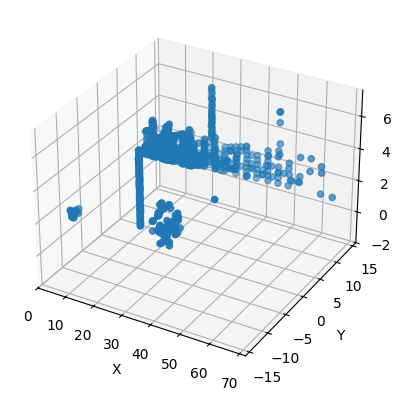

In [9]:
import matplotlib.pyplot as plt
import numpy as np

nvoxels_x = int((x_max - x_min) // vsize_xyz[0])
nvoxels_y = int((y_max - y_min) // vsize_xyz[1])
nvoxels_z = int((z_max - z_min) // vsize_xyz[2])
print(f'n voxels-xyz: ({nvoxels_x}, {nvoxels_y}, {nvoxels_z})')

pos_x = x_min + np.arange(0, nvoxels_x)*vsize_xyz[0]
pos_y = y_min + np.arange(0, nvoxels_y)*vsize_xyz[1]
pos_z = z_min + np.arange(0, nvoxels_z)*vsize_xyz[2]

# x = batchdata['sp_features'][ :2000, 0, 0]
# y = batchdata['sp_features'][ :2000, 0, 1]
# z = batchdata['sp_features'][ :2000, 0, 2]
x = batchdata['voxels'][ :2000, 0, 0]
y = batchdata['voxels'][ :2000, 0, 1]
z = batchdata['voxels'][ :2000, 0, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
plt.show()

In [10]:
print(x_min, x_max, y_min, y_max, z_min, z_max, vsize_xyz)

0.0 72.0 -16.0 16.0 -2.0 7.6 [0.05, 0.05, 0.1]


In [12]:
from spconv.pytorch import SparseConvTensor
from models.generatives.generative import *

gt_topk = 100
Nvoxels = 10000
radar_st = SparseConvTensor(features=batchdata['sp_features'].reshape((Nvoxels, -1)), 
                            indices=batchdata['sp_indices'].int(), #bzyx
                            spatial_shape=[z_size, y_size, x_size], 
                            batch_size=bs)

lidar_st = SparseConvTensor(features=batchdata['voxels'].reshape((Nvoxels, -1)), 
                            indices=batchdata['voxel_coords'].int(), #bzyx
                            spatial_shape=[z_size, y_size, x_size], 
                            batch_size=bs)

matched, gt_d, gt_f, gt_coords = local_match_closest_mdn(radar_st, lidar_st, gt_topk= gt_topk)

W0214 22:11:35.698000 2239364 torch/fx/_symbolic_trace.py:53] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


torch.Size([100, 3]) torch.Size([10000, 3])


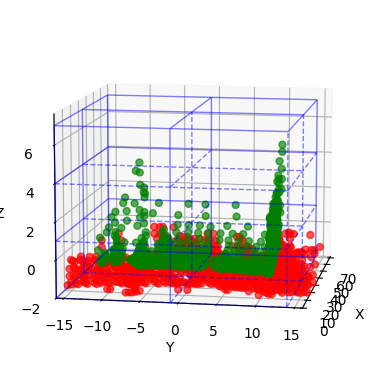

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def cube_edges_at(x0, y0, z0, sx, sy, sz):
    """
    Return list of 12 edges (each edge is 2 points) for a cube
    with corner at (x0,y0,z0) and side length s.
    """
    # 8 vertices
    v = np.array([
        [x0,   y0,   z0  ],
        [x0+sx, y0,   z0  ],
        [x0+sx, y0+sy, z0  ],
        [x0,   y0+sy, z0  ],
        [x0,   y0,   z0+sz],
        [x0+sx, y0,   z0+sz],
        [x0+sx, y0+sy, z0+sz],
        [x0,   y0+sy, z0+sz],
    ])

    # 12 edges as pairs of vertex indices
    edges_idx = [
        (0,1),(1,2),(2,3),(3,0),  # bottom
        (4,5),(5,6),(6,7),(7,4),  # top
        (0,4),(1,5),(2,6),(3,7)   # verticals
    ]
    return [(v[i], v[j]) for i, j in edges_idx]

def draw_voxel_wireframes(ax, pos_x, pos_y, pos_z, voxel_size,
                          color="w", linewidth=0.6, alpha=0.25):
    """
    Draw outlined voxel boxes for given voxel indices.
    """
    segs = []
    for x0 in pos_x:
        if x_max - x0 < 0.6*(voxel_size[0]):
            continue
        for y0 in pos_y:
            if y_max - y0 < 0.6*(voxel_size[1]):
                continue
            for z0 in pos_z:
                if z_max - z0 < 0.6*(voxel_size[2]):
                    continue
                segs.extend(cube_edges_at(x0, y0, z0, *voxel_size))

    lc = Line3DCollection(segs, colors=color, linewidths=linewidth, alpha=alpha)
    ax.add_collection3d(lc)

def set_equal_3d(ax, x_min, x_max, y_min, y_max, z_min, z_max):
    """Make 3D axes roughly equal scale (matplotlib doesn’t do this by default)."""
    cx, cy, cz = (x_min+x_max)/2, (y_min+y_max)/2, (z_min+z_max)/2
    r = max(x_max-x_min, y_max-y_min, z_max-z_min) / 2
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)
    try:
        ax.set_box_aspect((1,1,1))
    except Exception:
        pass

# ------------------ Example usage ------------------
points = batchdata['voxels']

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

segs_in = []
segs_out = []
gx, gy, gz = pos_x[::700], pos_y[::300], pos_z[::30]

for zi, gzz in enumerate(gz):
    for xi, gxx in enumerate(gx):
        if zi == gz.shape[0]-1 or xi == gx.shape[0]-1:
            segs_out.append([[gxx, gy[0], gzz], [gxx, gy[-1], gzz]])
        else:
            segs_in.append([[gxx, gy[0], gzz], [gxx, gy[-1], gzz]])

for zi, gzz in enumerate(gz):
    for yi, gyy in enumerate(gy):
        if zi == gz.shape[0]-1 or yi == 0:
            segs_out.append([[gx[0], gyy, gzz], [gx[-1], gyy, gzz]])
        else:
            segs_in.append([[gx[0], gyy, gzz], [gx[-1], gyy, gzz]])

for yi, gyy in enumerate(gy):
    for xi, gxx in enumerate(gx):
        if (yi==0 or xi == 0 or xi == gx.shape[0]-1) and not (xi==0 and yi==gy.shape[0]-1):
            segs_out.append([[gxx, gyy, gz[0]], [gxx, gyy, gz[-1]]])
        else:
            segs_in.append([[gxx, gyy, gz[0]], [gxx, gyy, gz[-1]]])

lc_in = Line3DCollection(segs_in, colors='blue', linewidths=1, alpha=0.5, linestyle='--')
lc_out = Line3DCollection(segs_out, colors='blue', linewidths=1, alpha=0.5, linestyle='-')
ax.add_collection3d(lc_in)
ax.add_collection3d(lc_out)

# draw_voxel_wireframes(ax, pos_x[::400], pos_y[::200], pos_z[::30], [s*t for (s, t) in zip(vsize_xyz, [400, 200, 30])],
#                       color="blue", linewidth=0.6, alpha=0.50)

rdr_points = batchdata['sp_features'][::10, 0, :]
ax.scatter(rdr_points[:, 0], rdr_points[:, 1], rdr_points[:, 2], s=25, alpha=0.65, color='r')


ldr_points = batchdata['voxels'][::10, 0, :]
ax.scatter(ldr_points[:, 0], ldr_points[:, 1], ldr_points[:, 2], s=25, alpha=0.65, color='g')

# optional: arrows like your figure (offsets)
base = rdr_points[::10, :3]
gt_d_xyz = torch.flip(gt_d, dims=[-1])
offsets = gt_d_xyz.mean(dim=1)*torch.tensor(vsize_xyz)
print(base.shape, offsets.shape)
# ax.quiver(base[:,0], base[:,1], base[:,2],
#           offsets[:,0], offsets[:,1], offsets[:,2],
#           length=1.0, normalize=False, linewidth=1.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
ax.view_init(elev=10, azim=190)
ax.invert_yaxis() 
# set_equal_3d(ax, points[:,0], points[:,1], points[:,2])
plt.show()

(1439, 639)


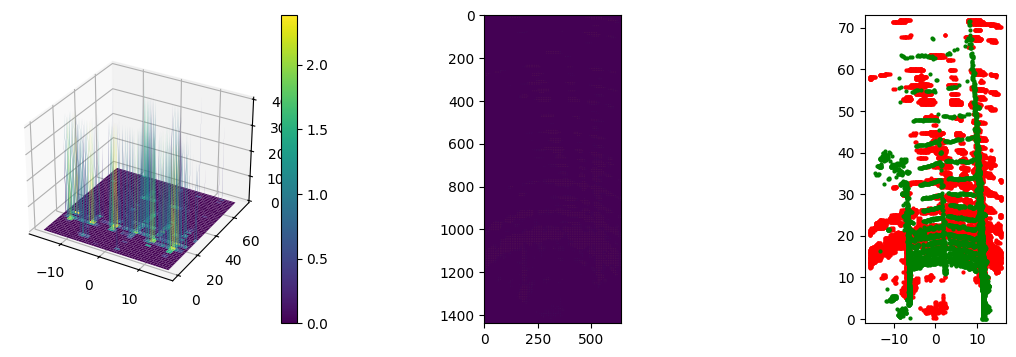

In [88]:
bev = np.zeros((pos_x.shape[0], pos_y.shape[0]))
print(bev.shape)
cnt = 0
for pi, ind in enumerate(radar_st.indices):
    b, z, y, x = ind
    # print(b, z, y, x)
    cnt +=1
    bev[x][y] += 10

fig1 = plt.figure(figsize=(14, 4))
ax1 = fig1.add_subplot(131, projection='3d')
X, Y = np.meshgrid(pos_y, pos_x)
surf = ax1.plot_surface(X, Y, bev,  cmap='viridis')
plt.colorbar(surf)

ax2 = fig1.add_subplot(132)
ax2.imshow(np.flipud(bev))

ax3 = fig1.add_subplot(133)
ax3.scatter(radar_st.features[:, 1], radar_st.features[:, 0], s=4, c='r')
ax3.scatter(lidar_st.features[:, 1], lidar_st.features[:, 0], s=4, c='g')
ax3.set_ylim([x_min-1, x_max+1])
ax3.set_xlim([y_min-1, y_max+1])
ax3.set_aspect('equal')